# WRF perturbations

In this work we compare WRF control output to output in which temperature or moisture have been perturbed around given vertical levels. The aim is to explore linear response functions as described in [Kuang 2010](https://doi.org/10.1175/2009JAS3260.1).

In [1]:
%cd git/wrf_lrf_les/

/home/561/tr2908/git/wrf_lrf_les


In [2]:
import sys
sys.path.append('analysis/')

import modules.wrf_perturbation as wp
import matplotlib.pyplot as plt
import numpy as np
import datetime
import dask
import xarray
import pandas as pd
import seaborn as sns
from dask.distributed import Client

print("Report last updated at " + str(datetime.datetime.utcnow()) + ' UTC.')

Report last updated at 2023-06-08 04:37:06.487806 UTC.


Start a dask cluster for parallel processing.

In [3]:
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:41979' processes=7 threads=28, memory=125.20 GiB>


## Settings

In [4]:
from importlib import reload
reload(wp)

<module 'modules.wrf_perturbation' from '/home/561/tr2908/git/wrf_lrf_les/analysis/modules/wrf_perturbation.py'>

In [5]:
# Perturbation details.
perts = {'res': ['4 km', '1 km', '100 m'],              # Dataset names.
         'dir': ['4km', '1km_Chimene', 'LES'],          # Dataset directories.
         'levels': ['850', '730', '600', '500', '412'], # Perturbed levels in hPa.
         'T': ['0.5', '-0.5'],                          # Temperature perturbations in K day-1.
         'q': ['0.0002', '-0.0002']}                    # Specific humidity perturbations in kg kg-1 day-1.

# Input directories with dataset names as keys.
basedir = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/'
inputs = wp.input_map(perts=perts, basedir=basedir)
    
# Figure settings.
plt.rcParams['figure.figsize'] = wp.FIGURE_SIZE  # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 16                   # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False # Don't use offsets in plots.

# The point at which the RCE run ends and control + perturbation runs begin.
runs_start = {'4 km': '2000-03-01',
              '1 km': '2000-03-01',
              '100 m':  '2000-04-26'} 

# Start and end times for designated RCE periods.
start_time = {'4 km': '2000-04-01',
              '1 km': '2000-04-01',
              '100 m':  '2000-05-20'}
end_time =   {'4 km': '2000-06-01',
              '1 km': '2000-06-01',
              '100 m':  '2000-05-27 06:00'}
               
plot_levels = [850, 500, 410, 100] # Pressure levels to plot individually [hPa].

### Simulated time periods

```
1 km:
RCE:            2000-01-01 to 2000-03-31
Control + pert: 2000-03-01 to 2000-05-31

4 km:
RCE:            2000-01-01 to 2000-03-31
Control + pert: 2000-03-01 to 2000-05-31

LES:
RCE:            2000-04-01 to 2000-04-26
Control + pert: 2000-04-26 to [...]

1 km no-ice:
RCE:            2000-01-01 to 2000-03-31
Control + pert: 2000-04-01 to 2000-05-31

1 km shear:
RCE:            2000-01-01 to 2000-03-31
Control + pert: 2000-03-01 to 2000-04-30
```

For LES RCE run, the initial profile and RCE profile to which stratospheric q is nudged are based on the 1 km RCE run from `2000-03-25` to `2000-03-31` (7 days at the end of the RCE run).

## WRF versions used for each run

The RCE run for 1 km no-ice, 1 km shear, 4 km, and LES were all made using a version of WRF in which 

 - Wind damping on U and V was to zero over the whole vertical column with a damping timescale of 4 days.
 - The wind tendencies `RURELAXTEN` and `RVRELAXTEN` were not properly added to the `halo` and `period` definitions, so incorrect values may have been used in the code that adds a staggered tendency field to an unstaggered tendency field (`add_a2c_u` and `add_a2c_v`). 
 
All other runs (control and perturbations plus RCE for remaining configs) were made using an updated version in which

 - Wind damping is applied with a three hour time scale above 100 hPa, decreasing to no damping below 160 hPa, except in wind shear case when wind shear is enforced by relaxing winds to shear profiles over the whole vertical column, with a three hour time scale.
 
Restarts were synchronised between runs. In the LES runs, runs for both negative and positive q perturbations at 850 hPa stopped 12 hours short of the expected run time in restart3 (the log files were accidentally overwritten in one case). restart4 was started 12 hours earlier for all runs, to rerun these sections.

## Data preparation

The script `~/code/sh/extract_WRF_variables_parallel.sh` runs, in parallel, a python script that extracts variables of interest from `wrfout` files, optionally interpolates the 3D variables to vertical pressure levels, and takes spatial means across horizontal dimensions. The pressure levels to which the interpolation is done are from 1000 to 100 hPa in 10 hPa increments. These profiles of mean values per time are written to `wrfvar` files, which are then opened here.

In [10]:
wrfvars = wp.read_wrfvars(inputs=inputs)

Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/RCE/): RCE...
Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/control/): Control...
Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/pert_850hPa_T_0.5K/): T 0.5 @850...
Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/pert_850hPa_T_-0.5K/): T -0.5 @850...
Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/pert_850hPa_q_0.0002kgkg-1/): q 0.0002 @850...
Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/pert_850hPa_q_-0.0002kgkg-1/): q -0.0002 @850...
Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/pert_412hPa_T_0.5K/): T 0.5 @412...
Reading 4 km dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/4km/pert_412hPa_T_-0.5K/): T -0.5 @412...
Reading 4 km dataset (/g/data/up

## Model setup

### Diffusion options

- **1km, 4km** (diff_opt=2, km_opt=4): diffusion for horiz, PBL handles vertical diffusion.
- **1km diff on, 4km diff on** (diff_opt=2, km_opt=2): diffusion on for both horiz/vertical, PBL also on.
- **1km no diff, 4km no diff** (diff_opt=0): no horiz diffusion, PBL handles vertical diffusion.

### Initial profiles

The model is initialised for the RCE run using a prescribed initial sounding/profile from the radiative–convective equilibrium model intercomparison project [(RCEMIP, Wing et al., 2018)](https://doi.org/10.5194/gmd-11-793-2018). Vertical levels are chosen using the [$\eta$-levels notebook](model_config/eta_levels.ipynb). Here we do some sanity checks on the `wrfinput` file that stores the initial model state, show basic settings and plot the initial profiles against the input sounding. The initial profiles are interpolated vertically in the `wrfinput` file using the initial sounding, and therefore should be almost identical to the sounding values by height. Note that the control and perturbation runs are restarted using an RCE `wrfrst` restart file, so there are no `wrfinput` files for these other runs.

In [ ]:
wp.model_setups(inputs=inputs)

### Vertical levels

The model heights are prescribed using the initial profiles and, at 1 km horizontal resolution, set so that the geopotential heights of the initial model state are  as close as possible to the height suggested for RCEMIP in [Wing et al., 2018](https://doi.org/10.5194/gmd-11-793-2018). Because the vertical levels are not constant in height or pressure (rather in $\eta$-value, see the [$\eta$-levels notebook](eta_levels.ipynb) for details), the vertical height of each level changes over time as the model settles to RCE. The following plot shows a comparison between the initial heights and the mean height of each level in the RCE period.

In [ ]:
#for res in wrfvars.keys():
#    wp.compare_vert_levels(init=wrfvars[res].sel(Dataset='RCE'), RCE=wrfvars[res].sel(Dataset='Control'),
#                           start=start_time[res], end=end_time[res], title=res)

### Surface temperatures

The surface is a flat water surface. We use a constant sea surface temperature (SST) set in the `namelist.input` file. The skin surface temperature (TSK) and deep soil temperature (TMN) are set to a constant value $T_s$ based on the initial surface pressure $p_s$ hPa, a reference pressure $p_0 = 100$ hPa, and surface potential temperature $\theta_s$ K, using 

$$
T_s = \theta_s \frac{p_s}{p_0}^{R_d/c_p}
$$

where $c_p$ (J kg$^{-1}$ K$^{-1}$) is specific heat capacity of dry air at constant pressure, and $R_d$ (J kg$^{-1}$ K$^{-1}$) is the gas constant for dry air.

In [ ]:
for res in inputs.keys():
    wp.surface_temps(wrf_file=inputs[res]['Control'] + '/wrfout_d01_' + 
                     start_time[res] + '_00:00:00', title=res)

### Fixed radiative cooling profile

The radiative cooling profile is kept fixed in all runs, following [Herman and Kuang (2013)](https://doi.org/10.1002/jame.20037). This constant radiation profile replaces the radiation driver entirely. Instead, the value of the potential temperature tendancy due to the radiation scheme ($\theta_{\textrm{tend, rad}}$ in K s$^{-1}$) is set based on the pressure $p$ at each mass point. The value is $\theta_{tend,rad} = t/\Pi$, where $\Pi$ is the Exner function that converts temperature to potential temperature, and $t$ is a temperature tendency set as follows:

 * $t = -1.5$ K day$^{-1}$ if $p \geq 200$ hPa.
 * $t = 0$ K day$^{-1}$ if $p \leq 100$ hPa.
 * $t$'s value varies linearly between -1.5 and 0 K day$^{-1}$ from 100 to 200 hPa.
 
Because $p$ and $\Pi$ are not constant, the values of potential temperature tendency vary slightly in time and space even though the cooling is constant, and the profiles of mean $\theta_{\textrm{tend,rad}}$ are curved. Here I plot mean $\theta_{\textrm{tend,rad}}$ (called `RTHRATEN` in the WRF model).

In [ ]:
#for res in wrfvars.keys():
#    wp.plot_radiative_cooling_profiles(dat=wrfvars[res], title=res)

The value of `RTHRATEN` is zero everywhere in the first model timestep since no tendency has been provided yet by the model. This first time step is excluded from the following plot which shows the tendancy due to the radiation scheme at various levels by time.

In [ ]:
#for res in wrfvars.keys():
#    wp.plot_radiative_cooling_by_level(dat=wrfvars[res], plot_levels=plot_levels, figsize=[10.7,5], title=res)

### Ideal evaporation / surface fluxes

We use ideal evaporation as per [Chua et al., 2019](http://dx.doi.org/10.1029/2019GL082408), such that surface wind is fixed at $W_s = 4.8$ m s$^{-1}$ and the drag coefficient is assumed to be 0.001. Then surface heat flux ($SH$) is calculated using modified Eq. 1 from Chua et al., 2019:

$$
SH = 0.001 \rho_a W c_p (T_s - T_a)
$$

where $\rho_a$ (kg m$^{-3}$) is the near surface air density, $T_s$ (K) is surface temperature (we use SST), and $T_a$ (K) is the near-surface air temperature. We use 

$$
T_a = T_l \left(\frac{p_s}{p_l}\right)^{\frac{R_d}{c_p}}
$$

where $T_l$ (K) is the temperature at the first model level above the surface, $p_s$ (hPa) is surface pressure, and $p_l$ (hPa) is pressure at the first model level. 

Latent heat flux (LH) is calculated using modified Eq. 2 from Chua et al., 2019, also assuming a drag coefficient of 0.001:

$$
LH = 0.001 \rho_a W L (q_{sat} - q_a)
$$

where $L$ is the typical latent heat of vaporization of water, $q_{sat}$ is the saturated water vapour mixing ratio at $T_s$ and $q_a$ is the water vapour mixing ratio at the lowest model level. Note that while Chua et al., 2019 assume that air density near the surface is 1 kg m$^{-3}$, we use the density value produced by WRF which is around 1.16 kg m$^{-3}$ using the current model setup.

### Stratospheric temperature and moisture relaxation

For 1 km and 4 km runs, potential temperature and water vapour mixing ratio $q$ are relaxed in the stratosphere (above 160 hPa) to reference RCE profiles, as suggested by [Herman and Kuang (2013)](https://doi.org/10.1002/jame.20037). The reference profile is stored as a value for $T$ and $q$ per vertical level index, not per pressure. The assumption is that the pressure for each vertical level will not change markedly after RCE. The reference profile is the profile from the RCEMIP project for the 1 km and 4 km runs, and a the mean 1 km RCE profile over 7 days at the end of the 2000-03 for the LES runs.

The following plots show mean profiles of $T$ and $q$ in at interpolated pressure levels (black line), with blue shading showing the range of the values across the entire runs and red points showing the RCE value at eta-level pressures.

In [ ]:
# wp.plot_RCE_tq_profiles(inputs=inputs, wrfvars=wrfvars, start_time=start_time, end_time=end_time)

## Perturbation settings

Here are perturbation settings used in each run:

In [ ]:
wp.perturbation_details(inputs)

### Perturbed pressure level

#### Kuang 2012

In [Kuang 2012](https://doi.org/10.1175/JAS-D-11-0307.1), the forcing form is given in Appendix A:

$$
f_i = \frac{1}{2} \left\{ \delta_{ij} + \exp\left[ - \left( \frac{p_j - p_i}{75 \textrm{hPa}}\right)^2 \right] \right\}
$$

where $f_i$ is the perturbation forcing applied to the $i$th model level, $\delta_{ij}$ is a Direct delta function returns $0$ when $i \neq j$ and $1$ when $i = j$, and $p_j$ and $p_i$ are pressure at the $j$th and $i$th levels respectively (hPa). The point around which to perturb is chosen by selecting a level $j$ which will receive the maximum perturbation. 

#### Herman and Kuang 2013

A similar equation is shown in [Herman and Kuang 2013](https://doi.org/0.1002/jame.20037) Equation 4, and although they claim it is identical to the above equation it is missing the division by two, so it is written

$$
f_i = \delta_{ij} + \exp\left[ - \left( \frac{p_j - p_i}{75 \textrm{hPa}}\right)^2 \right]
$$

#### Our choice of basis function

Because the pressure levels in our model are not exactly at the points around which we want to perturb, I have adapted this form so that only the Gaussian portion of the function is used, and instead of selecting a level $k$ we select a pressure $p_p$ (hPa) around which to perturb:

$$
f_i = \exp\left[ - \left( \frac{p_p - p_i}{75 \textrm{hPa}}\right)^2 \right]
$$

The following plot shows the difference made by this change in the shape of the perturbation forcing by pressure.

In [ ]:
# wp.compare_perturbation_forcing(dat=wrfvars['1 km'].sel(Dataset='Control'), p_pert=850, k_pert=10)

The model pressure at the kth eta level will vary slightly in space and time. Here is the range of pressure values observed for this level in the perturbed run, and a plot of the minimum and maximum values.

## Radiative-convective equilibrium (RCE)

### Time series of precipitable water

To determine when the simulations have reached RCE, we look for stabilisation of the precipitable water (PW) field. Here is spatially-averaged PW by time for each simulation. The green highlighted region is the time span over which average profiles are calculated for all runs.

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(13,14))
for i, res in enumerate(wrfvars.keys()):
    wrfvars[res].pw.plot(hue='Dataset', ax=axs[i])
    axs[i].axvspan(xmin=start_time[res], xmax=end_time[res], alpha=0.3, color='green')
    axs[i].set_title(res)
    if i != 0:
        axs[i].get_legend().remove()
    else:
        sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
        
for ax in axs:
    ax.set_ylabel('Precipitable water\n[kg m$^{-2}$]')
    ax.set_xlabel('')
    
plt.tight_layout()
plt.savefig(f'paper/figures/RCE_PW.pdf', bbox_inches='tight')
plt.show()
plt.close()

From now on we remove the 'RCE' dataset, since the reference dataset is 'Control'.

In [74]:
for res in wrfvars.keys():
    wrfvars[res] = wrfvars[res].drop_sel(Dataset='RCE').sel(time=slice(runs_start[res], None))
    del(inputs[res]['RCE'])

### Convective structure during RCE

Since we do not use the radiation driver, outgoing longwave radiation (OLR) is not calculated in our runs and it is not trivial to visualise the locations of convection. Instead we plot the location of rainfall calculated (without the convective scheme) for the first day of each RCE period. The x and y axes in these plots are pixel numbers.

In [ ]:
#wp.plot_daily_rain(inputs=inputs, figsize=(14,6), #patterns={'1 km': 'wrfout*'+start_time['1 km']+'*'})
#                   patterns={res:'wrfout*'+time+'*' for (res,time) in start_time.items()})

## Other profiles by time

### Temperature

In [ ]:
wp.plot_profiles_by_time(dat=wrfvars, variable='tk')
wp.plot_levels_by_time(dat=wrfvars, variable='tk', plot_levels=plot_levels)

### Water vapour mixing ratio

In [ ]:
wp.plot_profiles_by_time(dat=wrfvars, variable='q')
wp.plot_levels_by_time(dat=wrfvars, variable='q', plot_levels=plot_levels)

### Relative humidity

In [ ]:
wp.plot_profiles_by_time(dat=wrfvars, variable='rh')
wp.plot_levels_by_time(dat=wrfvars, variable='rh', plot_levels=plot_levels)

## Addition of mass flux

Convective mass flux is 

$$M_c = \rho \sigma w_{up}$$

Where $\sigma$ is the fraction of area covered by updrafts, $w_{up}$ is the average vertical velocity over all updraft areas, and $\rho$ is air density.

In [ ]:
wrfvars = wp.add_mass_flux(wrfvars)

# Mean profiles over RCE period

In [11]:
profs = {}
for res in wrfvars.keys():
    profs[res] = wp.mean_profiles(dat=wrfvars[res], start=start_time[res], end=end_time[res], plot=False,
                                  title=res + ' (' + str(start_time[res]) + ' to ' + str(end_time[res]) + ')')

Variance in differences:

In [109]:
quants = []
for res in wrfvars.keys():
    dat=wrfvars[res]
    start=start_time[res]
    end=end_time[res]

    d = dat.sel(time=slice(start, end))
    diffs = (d - d.sel(Dataset='Control')).drop_sel(Dataset='Control')
    diffs = diffs[['T', 'tk', 'q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup', 'rh']]
    diffs = diffs.chunk({'time': -1}).load()

    quants.append(diffs.quantile(q=[0.5, 0.9, 0.1], dim='time').expand_dims({'res': [res]}))
    
quants = xarray.merge(quants)

Task exception was never retrieved
future: <Task finished name='Task-3073045' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/client.py:2176> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/client.py", line 2185, in wait
    raise AllExit()
distributed.client.AllExit
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 11.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [112]:
quants = quants.to_dataframe().reset_index()

In [132]:
foo = quants[quants['quantile'] == 0.5]
foo[foo.res == '1 km']

,level,Dataset,quantile,res,T,tk,q,qcloud,qice,qsnow,qrain,qgraup,rh
0,1000,T -0.5 @412,0.5,1 km,-0.269279,-0.269241,-4.507094e-04,0.0,0.0,0.0,4.751126e-08,0.0,-1.122486
9,1000,T -0.5 @500,0.5,1 km,-0.269377,-0.269348,-4.344359e-04,0.0,0.0,0.0,3.045824e-07,0.0,-1.072563
18,1000,T -0.5 @600,0.5,1 km,-0.265933,-0.265915,-4.219385e-04,0.0,0.0,0.0,2.808536e-07,0.0,-1.005793
27,1000,T -0.5 @730,0.5,1 km,-0.262522,-0.262497,-4.233550e-04,0.0,0.0,0.0,1.613241e-07,0.0,-1.053363
36,1000,T -0.5 @850,0.5,1 km,-0.281686,-0.281662,-4.191212e-04,0.0,0.0,0.0,2.847231e-07,0.0,-0.874768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16335,100,q 0.0002 @412,0.5,1 km,-0.009861,-0.004860,-2.397493e-08,0.0,0.0,0.0,0.000000e+00,0.0,-0.070378
16344,100,q 0.0002 @500,0.5,1 km,-0.030937,-0.016029,-1.473504e-08,0.0,0.0,0.0,0.000000e+00,0.0,-0.041211
16353,100,q 0.0002 @600,0.5,1 km,-0.056835,-0.029327,-3.968864e-09,0.0,0.0,0.0,0.000000e+00,0.0,-0.005500
16362,100,q 0.0002 @730,0.5,1 km,-0.037025,-0.019196,-3.196547e-09,0.0,0.0,0.0,0.000000e+00,0.0,-0.007502


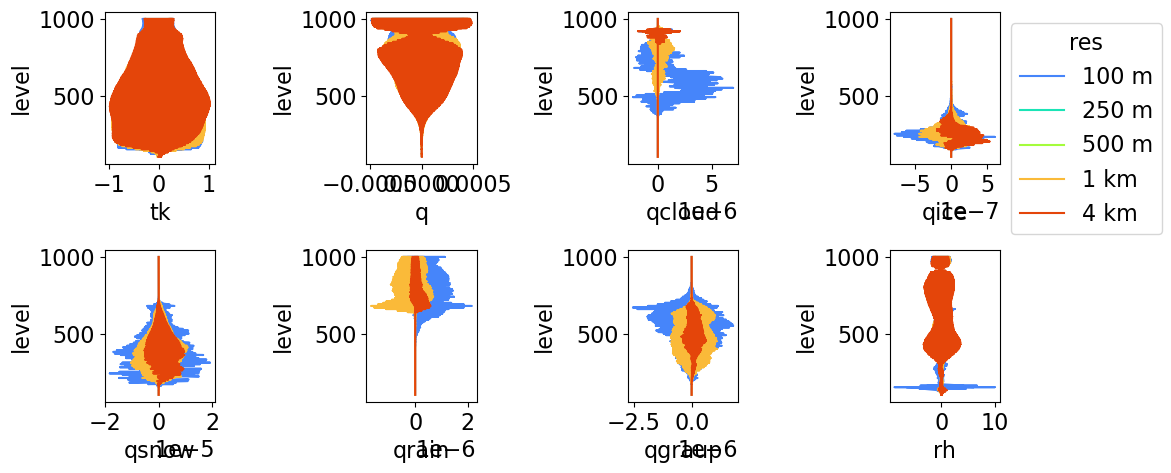

In [130]:
variables = ['tk', 'q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup', 'rh']

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,5))

for i, v in enumerate(variables):
    
    sns.lineplot(data=quants[quants['quantile']==0.5], ax=axs.flat[i], x=v, y='level', linestyle='-', hue='res', sort=False, estimator=None, legend=(i == ncols-1),
                 hue_order=['4 km', '1 km', '500 m', '250 m', '100 m'][::-1], palette=sns.color_palette("turbo", 5), zorder=5)
        
    
sns.move_legend(axs.flat[ncols-1], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
profs = {}
for res in wrfvars.keys():
    
    dat=wrfvars[res]
    start=start_time[res]
    end=end_time[res]
    
    
    
     = dat.sel(time=slice(start, end)).mean('time', keep_attrs=True)

## Perturbation differences in averaged RCE profiles

Differences here are defined as `perturbed - control`. The red vertical line shows zero difference.

In [12]:
monc = wp.MONC_data()
monc['model'] = 'MONC'

# Hydrometeor classes for MONC at 500 and 250 m are in 1000 * g kg-1.
lores = monc[~np.logical_or(monc.res == '500 m',
                           monc.res == '250 m')].copy()
hires = monc[np.logical_or(monc.res == '500 m',
                           monc.res == '250 m')].copy()
for particle in ['qcloud', 'qice', 'qsnow', 'qrain', 'qgraup']:
    hires[particle] = hires[particle].copy() / 1000
monc = pd.concat([lores, hires])

In [13]:
# Collect WRF differences together in the same form as the MONC differences.
wrf_profs = xarray.merge([profs[x][['T', 'tk', 'q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup', 'rh']].load().expand_dims({'res': [x]}) for x in profs])

# Convert quantities in kg kg-1 to g kg-1.
for v in ['q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup']:
    wrf_profs[v] = wrf_profs[v]*1000
    
wrf_diffs = wrf_profs.drop_sel(Dataset='Control') - wrf_profs.sel(Dataset='Control')

wrf = wrf_diffs.to_dataframe().reset_index()
wrf['model'] = 'WRF'
wrf = wrf.rename(columns={'Dataset': 'pert', 'level': 'pressure'})

# Collect WRF and MONC differences together.
diffs = pd.concat([wrf, monc]).reset_index(drop=True)
diffs = diffs.sort_values(['pressure', 'model', 'res'], ascending=False)
diffs = diffs.rename(columns={'model': 'Model', 'res': 'Resolution'})

# Give hydrometeors a factor of 1e3
for v in ['q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup']:
    diffs[v] = diffs[v]*1000
    
diffs['pert_group'] = [x.replace('-', '') for x in diffs.pert]
diffs['neg'] = ['-' in x for x in diffs.pert]

pos = diffs[~diffs.neg].copy()
neg = diffs[diffs.neg].copy()

for v in ['T', 'tk', 'q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup', 'rh']:
    neg[v] = -1 * neg[v]
    
diffs = pd.concat([neg, pos])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 10.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


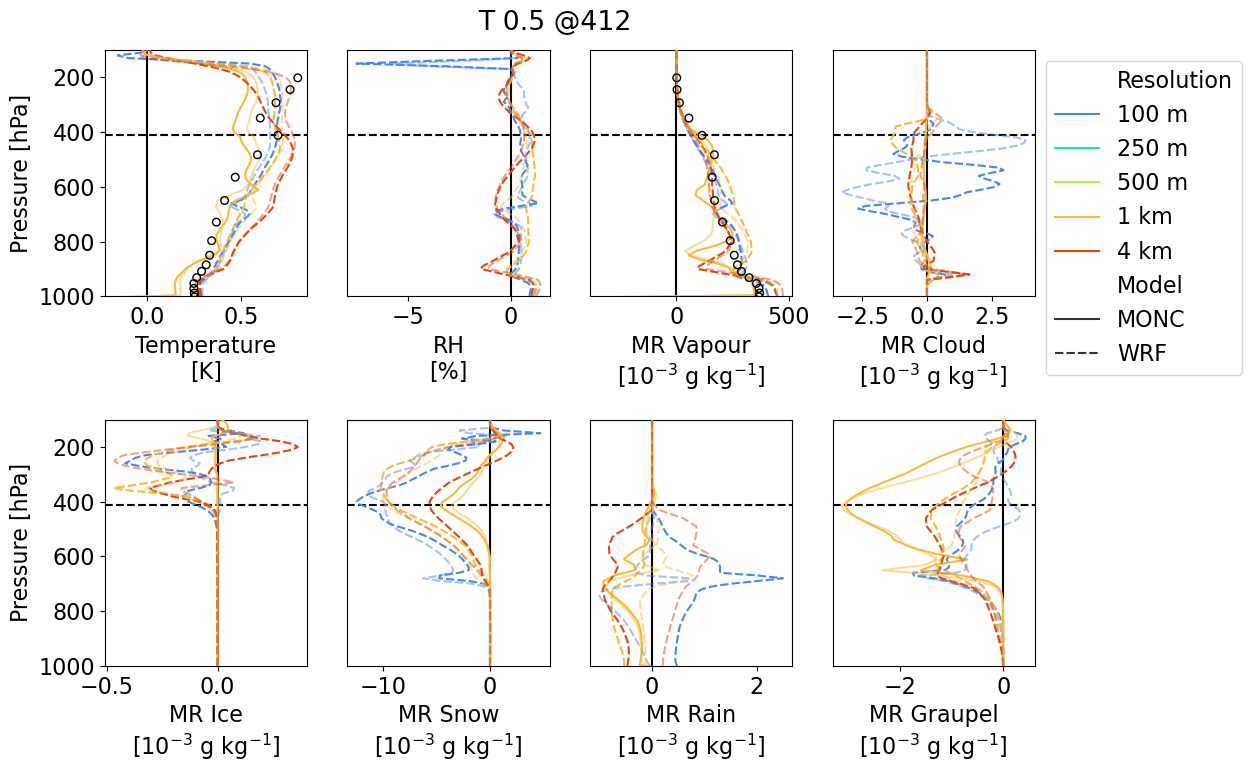

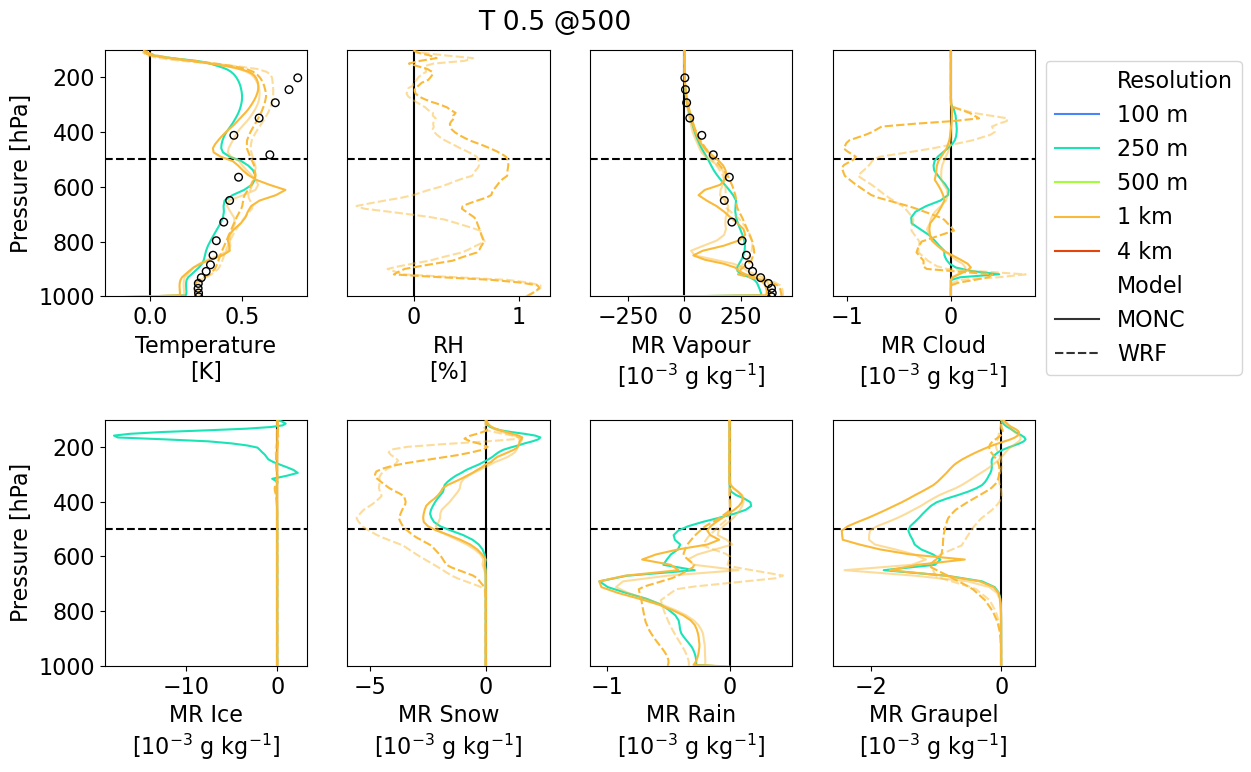

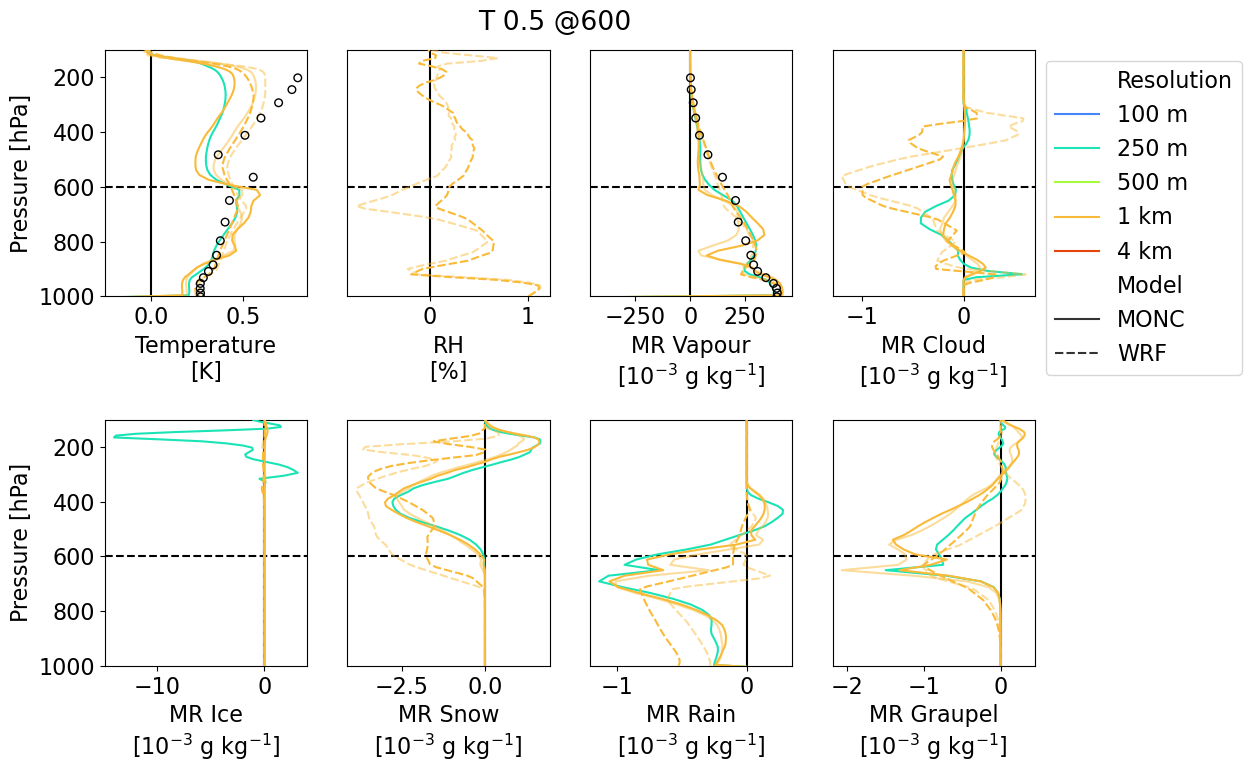

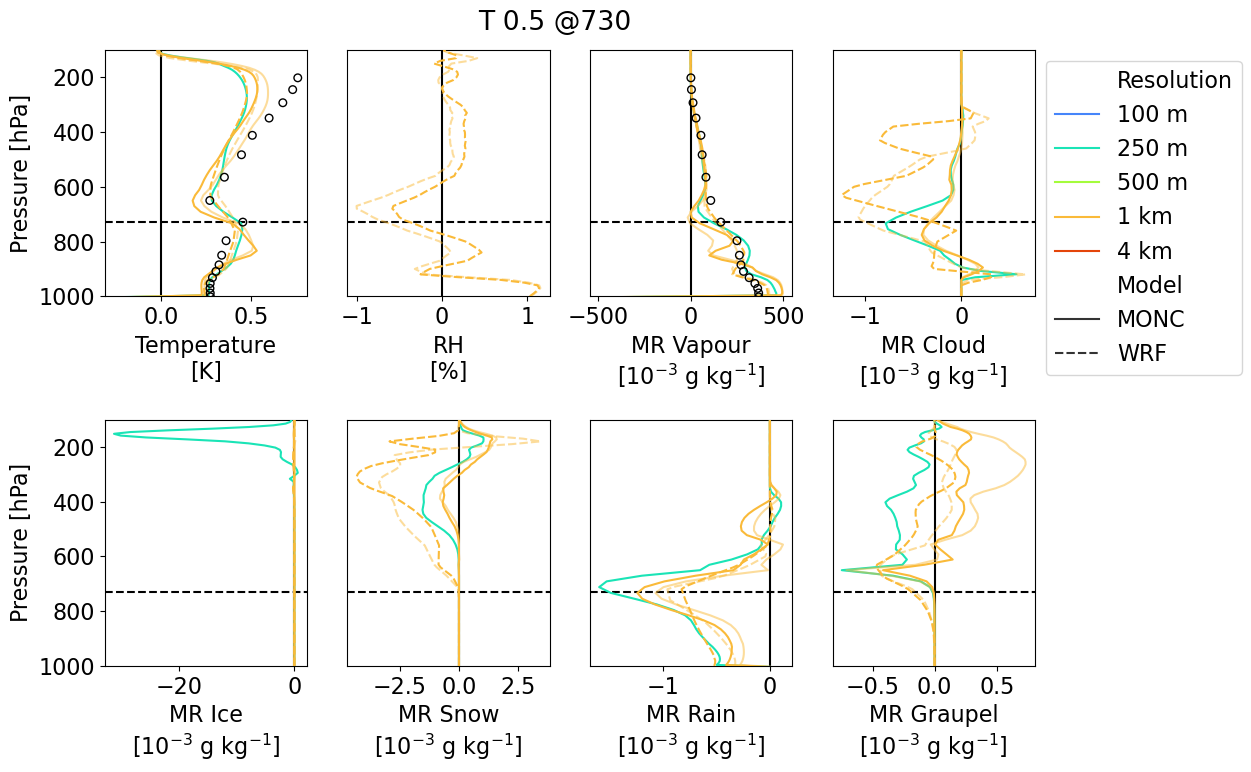

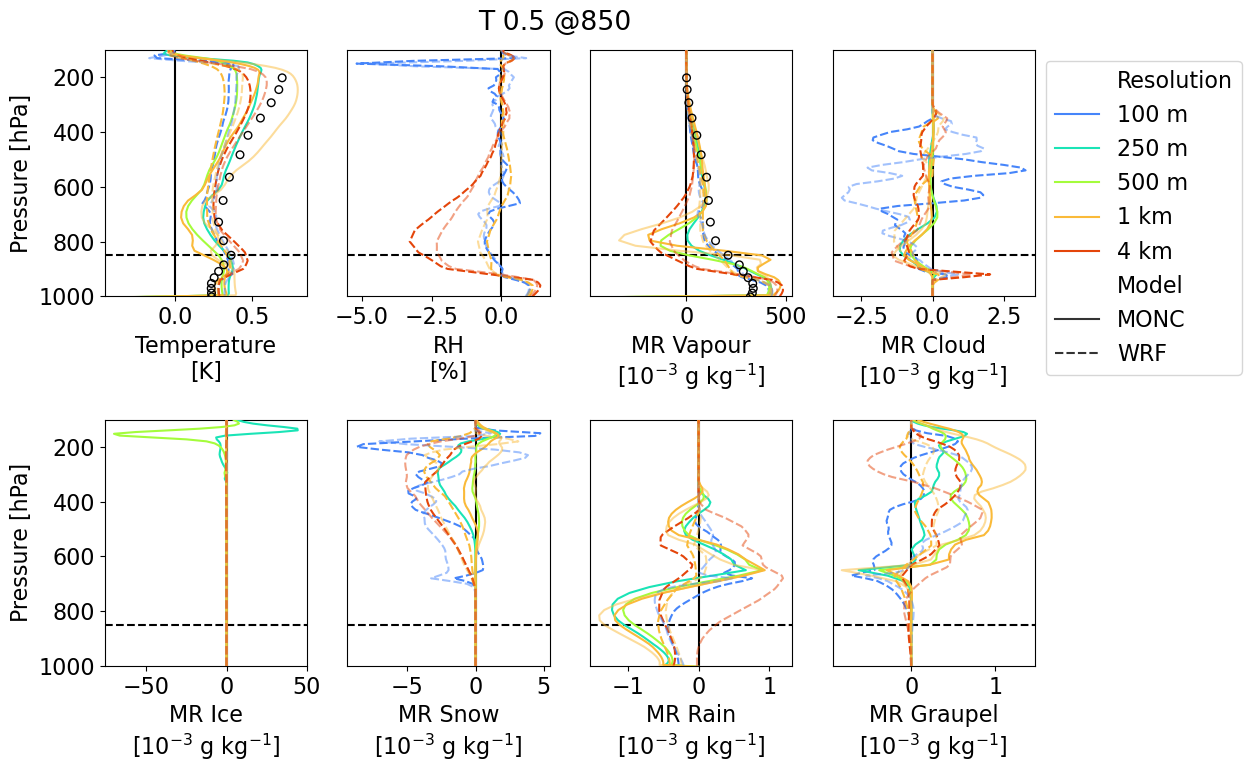

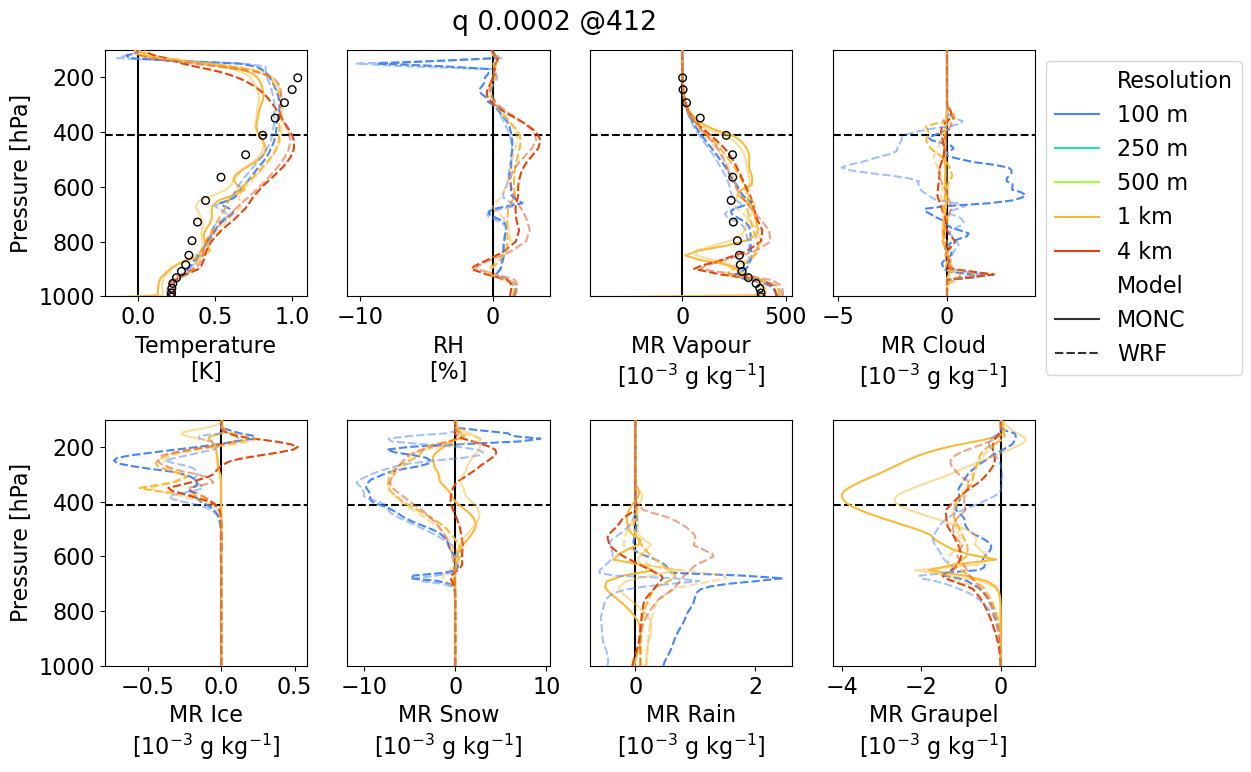

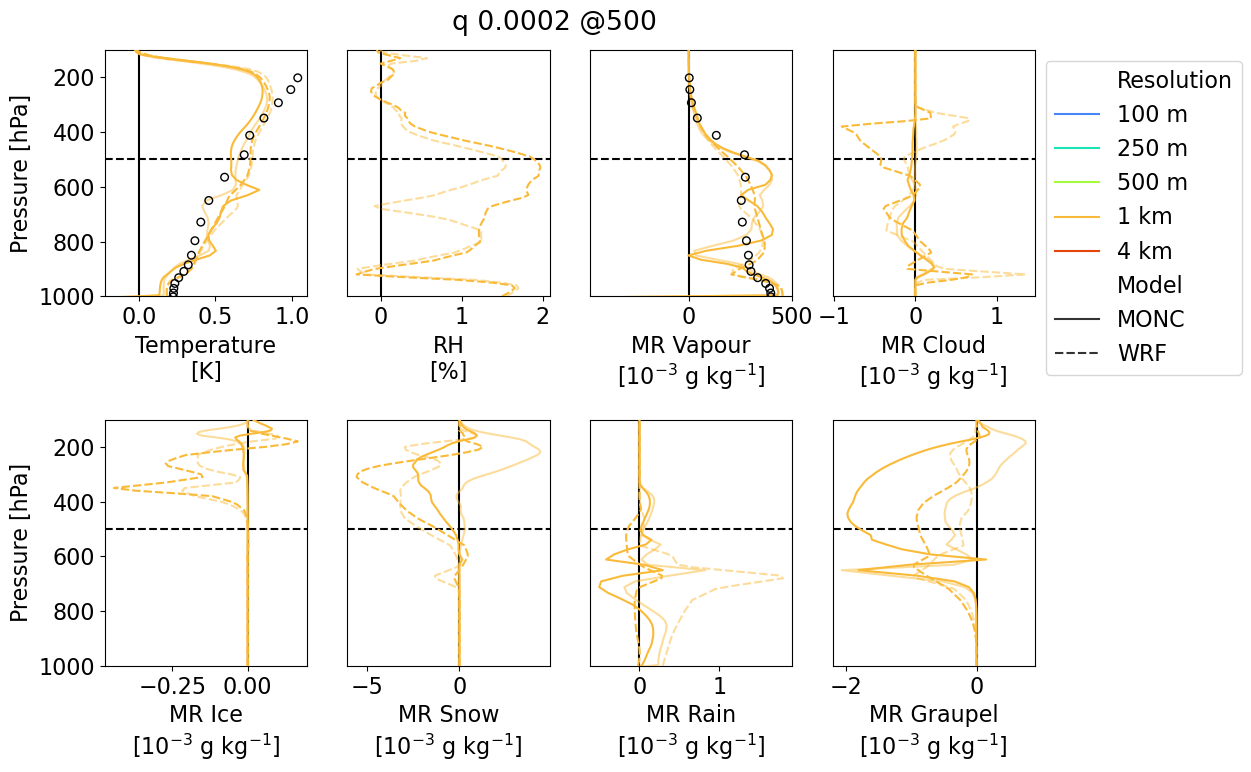

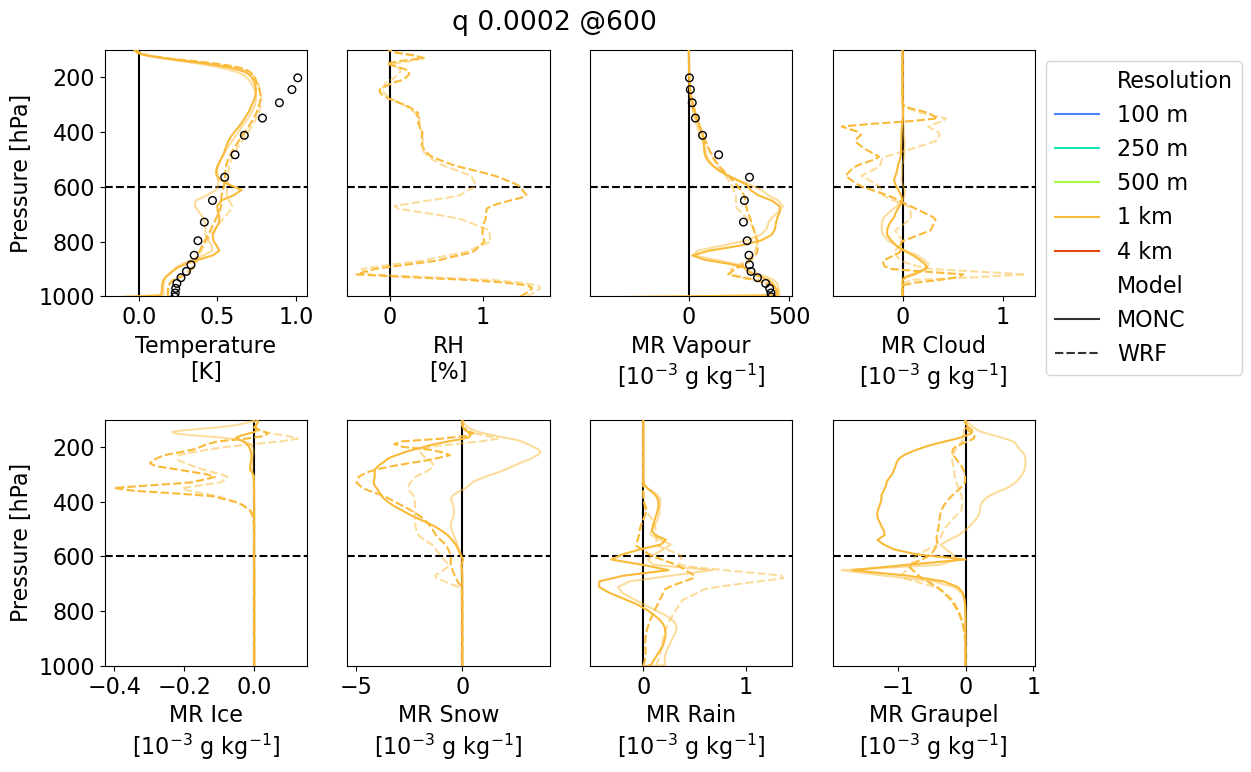

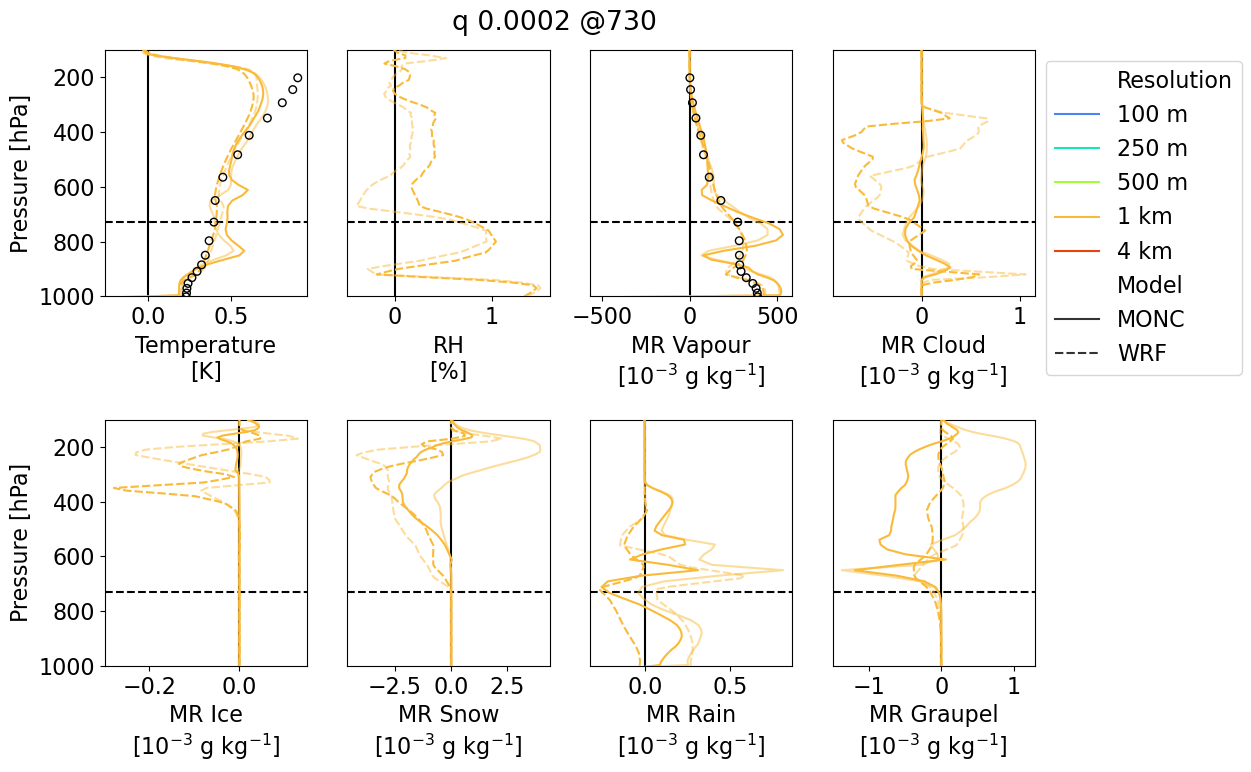

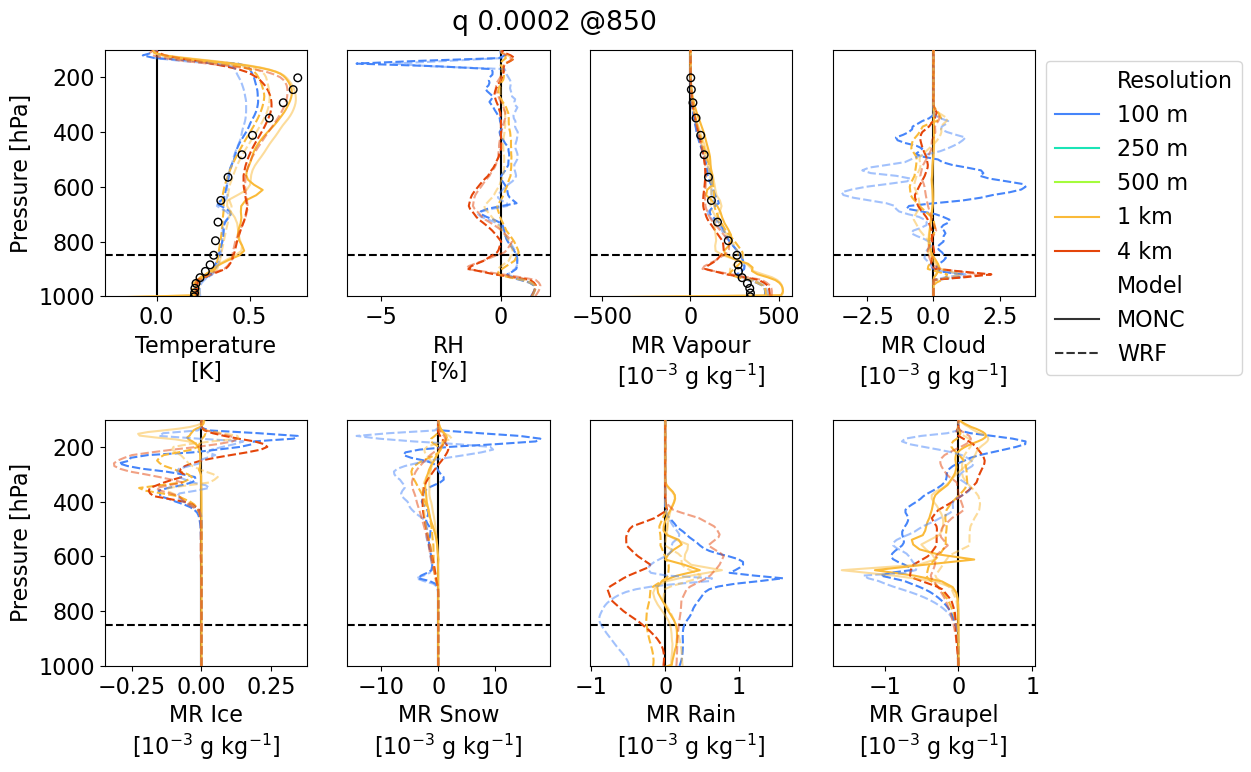

In [70]:
perts = [x for x in np.unique(diffs.pert_group) if x[0] == 'T' or x[0] == 'q']
for p in perts:
    p_level = float(p[-3:])
    variables = ['tk', 'rh', 'q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup']
    var_labels = {'tk': 'Temperature\n[K]',
                  'rh': 'RH\n[%]',
                  'q': 'MR Vapour\n[10$^{-3}$ g kg$^{-1}$]',
                  'qcloud': 'MR Cloud\n[10$^{-3}$ g kg$^{-1}$]',
                  'qice': 'MR Ice\n[10$^{-3}$ g kg$^{-1}$]',
                  'qsnow': 'MR Snow\n[10$^{-3}$ g kg$^{-1}$]',
                  'qrain': 'MR Rain\n[10$^{-3}$ g kg$^{-1}$]',
                  'qgraup': 'MR Graupel\n[10$^{-3}$ g kg$^{-1}$]'}
    figsize = (12,8)
    ncols = 4
    nrows = 2
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, gridspec_kw={'hspace': 0.5})

    assert len(variables) <= ncols * nrows, 'Not enough col/rows.'

    d = diffs[diffs.pert_group == p]
    d = d[d.pressure >= 100]

    for i, variable in enumerate(variables):
        axs.flat[i].axvline(0, color='black')
        axs.flat[i].axhline(p_level, color='black', linestyle='--')

        sns.lineplot(data=d[~d.neg], x=variable, y='pressure', ax=axs.flat[i], style='Model', hue='Resolution', sort=False, estimator=None, legend=(i == ncols-1),
                     hue_order=['4 km', '1 km', '500 m', '250 m', '100 m'][::-1], palette=sns.color_palette("turbo", 5), zorder=5)
        
        if len(d[d.neg]) > 0:
            sns.lineplot(data=d[d.neg], x=variable, y='pressure', ax=axs.flat[i], style='Model', hue='Resolution', sort=False, estimator=None,
                         hue_order=['4 km', '1 km', '500 m', '250 m', '100 m'][::-1], palette=sns.color_palette("turbo", 5), alpha=0.5, legend=False, zorder=5)
        axs.flat[i].invert_yaxis()

        axs.flat[i].set_ylim(1000, 100)

        # Add Kuang 2010 reference values.
        if variable == 'q':
            r = refs[refs.Dataset == p]
            axs.flat[i].scatter(r.q * 1000, r.level, facecolors='none', edgecolors='black', zorder=10, s=30)
        if variable == 'tk':
            r = refs[refs.Dataset == p]
            axs.flat[i].scatter(r.tk, r.level, facecolors='none', edgecolors='black', zorder=10, s=30)
        
        if variable in var_labels:
            axs.flat[i].set_xlabel(var_labels[variable])

        if i % ncols == 0:
            axs.flat[i].set_ylabel('Pressure [hPa]')
        else: 
            axs.flat[i].set_ylabel('')
            axs.flat[i].set_yticks([])

    sns.move_legend(axs.flat[ncols-1], 'upper left', bbox_to_anchor=(1, 1))
    _ = plt.suptitle(p, y=0.93)
    plt.savefig(f'paper/figures/pert_diffs_{p.replace(" ", "_")}.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

In [66]:
reload(wp)

<module 'modules.wrf_perturbation' from '/home/561/tr2908/git/wrf_lrf_les/analysis/modules/wrf_perturbation.py'>

In [67]:
refs = wp.kuang_data(ref_dir='/g/data/up6/tr2908/LRF_SCM_results/')
refs

{0: 1002, 1: 988, 2: 971, 3: 953, 4: 932, 5: 909, 6: 885, 7: 850, 8: 797, 9: 729, 10: 650, 11: 565, 12: 483, 13: 412, 14: 349, 15: 293, 16: 245, 17: 202}


,level,Dataset,perturbed,q,tk
0,202,T 0.5 @412,T,0.001413,0.803679
1,202,q 0.0002 @412,q,0.001608,1.036130
2,202,T 0.5 @500,T,0.001906,0.800018
3,202,q 0.0002 @500,q,0.002486,1.038396
4,202,T 0.5 @600,T,0.001653,0.801155
...,...,...,...,...,...
175,1002,q 0.0002 @600,q,0.409510,0.230006
176,1002,T 0.5 @730,T,0.366766,0.273995
177,1002,q 0.0002 @730,q,0.388465,0.227722
178,1002,T 0.5 @850,T,0.321463,0.238815


In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        diffs = wp.calc_profile_diffs(profs=sub, neg=[x for x in ds if '-' in x])
        break
    break

In [ ]:
diffs#.to_dataframe()

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            xlims={'tk': [-0.1,1.2],
                                   'q': [-0.00025, 0.0005],
                                   'rh': [-4, 7]})
        break
    break

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            variables=['conv_mass_flux', 'wa'],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            xlims={'conv_mass_flux': [-0.011, 0.005],
                                   'wa': [-0.0002, 0.0003]})

## Extra scripts

In [ ]:
#direc = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km/pert_412hPa_q_-0.0002kgkg-1/'
#d = xarray.open_mfdataset(direc + 'wrfout*', concat_dim='Time', combine='nested')
#
#theta = d.T + 300
#p = (d.P + d.PB) / 100
#q = d.QVAPOR
#
#import modules.atmosphere as at
#rh = at.relative_humidity(theta=theta, p=p, q=q)
#
#minval_all = np.round(rh.min().values, 2)
#maxval_all = np.round(rh.max().values, 2)
#minval_trop = np.round(rh.where(p > 160).min().values, 2)
#maxval_trop = np.round(rh.where(p > 160).max().values, 2)
#
#rh.plot.hist(bins=80, label='All data', histtype='step', density=True)
#rh.where(p > 160).plot.hist(bins=80, label='> 160 hPa', histtype='step', density=True)
#plt.title('Distributions as densities\nAll data range: ' + str(minval_all) + '% to ' + str(maxval_all) + 
#          '%\n> 160 hPa range: ' +
#          str(minval_trop) + '% to ' + str(maxval_trop) + '%')
#plt.legend()
#plt.show()

In [ ]:
# For computing shear profile from 1 km RCE pressure/height combinations.
#
# import xarray
# out = xarray.open_mfdataset(basedir + '1km/control/wrfout_d01_*', combine='nested', concat_dim='Time')
# pres = ((out.P + out.PB) * 0.01).mean(['south_north', 'west_east','Time'])
# height = ((out.PH + out.PHB) / 9.81).mean(['south_north', 'west_east','Time'])
# height = (height[1:] + height[:-1]) / 2
# plt.plot(pres, height)

# from scipy import interpolate
# f = interpolate.interp1d(x=[pres.max(), 500, 160, pres.min()], y=[0,5,0,0])
# shear_prof = f(pres.values)

# plt.scatter(shear_prof, pres.values, color='black')
# plt.plot(shear_prof, pres.values)
# plt.gca().invert_yaxis()

#np.savetxt(basedir+'/U_profile.shear', shear_prof, fmt='%f')

In [ ]:
# Calculating shear for wind shear experiments -- to write to input_sounding and U_target files.

# import modules.rcemip_profile as rcemip
# import pandas as pd
# import xarray

# heights = rcemip.suggested_heights()
# sheared_U = wp.shear_profile(z=heights)

# # Update input sounding.
# d = pd.read_table('.../input_sounding.1km_shear', skiprows=1, names=['z', 'T', 'q', 'U', 'V'])
# d.U = sheared_U
# d.to_csv('/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/input_sounding.1km_shear2', sep='\t', index=False)

# # Also write U_target file to match.

# plt.plot(sheared_U, heights)
# plt.xlabel('U wind speed [m s-1]')
# plt.ylabel('Initial model height [m]')
# plt.gca().set_ylim([0,12000])
# plt.gca().set_xlim([0,25])
# plt.grid(which='both')
# plt.show()

# # Check wrfinput file.
# inp = xarray.open_dataset('/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/run/1km_shear/RCE/wrfinput_d01')
# inp.U.mean(['Time', 'south_north', 'west_east_stag'])

### TODO:

- Make all perturbation difference plots have the same axes for comparisons. Only plot up to 200 hPa because we don't care about what's happening in the stratosphere above.
- Compare results directly to Charmaine and Kuang results.
- Q we want to answer - do we have a benchmark? What do we require to have a benchmark?
- Check which turbulence closure scheme was used. Rerun 1km runs with different turbulence scheme to see differences.
- Try to figure out why the domain is drying out at about 850 hPa. 